In [1]:
from IPython.display import Image, display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

# Table of Contents

[Introduction](#1)

[Technological Process](#2)

[Data Description](#3)

[Feature Naming](#4)

[Section 1: Preparing the Data](#5)
- [PART A: Opening the Files and Looking Into the Data](#5.1)
- [PART B: Checking That Recovery Is Calculated Correctly](#5.2)
- [PART C: Analyzing the Features Not Available In the Test Set](#5.3)
- [PART D: Performing Data Preprocessing](#5.4)

[Section 2: Analyzing the Data](#6)
- [PART A: Noting Change In Concentrations of Metals Depending On the Purification Stage](#6.1)
- [PART B: Comparing the Feed Particle Size Distributions In the Training Set and In the Test Set](#6.2)
- [PART C: Are There Any Abnormal Values In the Total Distribution?](#6.3)

[Section 3: Building the Model](#7)
- [PART A: Writing a Function to Calculate the Final sMAPE Value](#7.1)
- [PART B: Training Different Models and Testing the Best One Using the Test Sample](#7.2)

[Conclusion](#8)

# Introduction <a id=1></a>

I am a data scientist for **Zyfra**, a company that develops efficiency solutions for heavy industry. In this project, I prepare a prototype of a machine learning model that predicts the amount of gold recovered from ore. This model will help **Zyfra** optimize product, and eliminate unprofitable parameters. To help me build the model, I have data on the extraction and the purification of ore.

# Technological Process <a id=2></a>

Gold is extracted from ore via the following process:

Mined ore undergoes primary processing to get the **ore mixture** (also called the **rougher <u>feed</u>**), which is the raw material for **flotation** (also called the **rougher <u>process</u>**). 

Flotation is when gold (Au) ore mixture is fed into the float **banks**, which obtain either **rougher (gold) concentrate** or **rougher tails** (which are product residues with a low concentration of valuable metals).

After flotation, the **rougher concentrate** undergoes two stages of purification, after which there are the final concentrate and new rougher tails. Note that the rougher tails might be identified during flotation or during one of the two purification stages.

In [2]:
display(Image(url = 'https://practicum-content.s3.us-west-1.amazonaws.com/resources/moved_viruchka_2_1589899167.jpg'))

# Data Description <a id=3></a>

Regarding the technological process, note the following terms:

<b>Rougher feed</b> — Raw material

<b>Rougher additions</b> (also called flotation reagents) — <i>Xanthate</i>, <i>Sulphate</i>, <i>Depressant</i>

- <i><b>Xanthate</b></i> — Promoter or flotation activator

- <i><b>Sulphate</b></i> — Sodium sulphide for this particular process

- <i><b>Depressant</b></i> — Sodium silicate

<b>Rougher process</b> — Flotation

<b>Rougher tails</b> — Product residues

<b>Float banks</b> — Flotation unit

<b>Cleaner process</b> — Purification

<b>Rougher Au</b> — Rougher gold concentrate

<b>Final Au</b> — Final gold concentrate

# Feature Naming <a id=4></a>

The features of my machine learning model are named using the following format: ```[stage].[parameter_type].[parameter_name]```

Possible values for ```[stage]```:

- <b>rougher</b> — Flotation

- <b>primary_cleaner</b> — Primary purification

- <b>secondary_cleaner</b> — Secondary purification

- <b>final</b> — Final characteristics

Possible values for ```[parameter_type]```:

- <b>input</b> — Raw material parameters

- <b>output</b> — Product parameters

- <b>state</b> — Parameters characterizing the current state of the stage

- <b>calculation</b> — Calculation characteristics

Possible values for ```[parameter_name]```
- <b>air_amount</b> — Volume of air
- <b>fluid levels</b> — Levels of fluid
- <b>feed_size</b> — Feed particle size
- <b>feed_rate</b> — Feed particle rate

In [3]:
display(Image(url = 'https://practicum-content.s3.us-west-1.amazonaws.com/resources/moved_ore_1591699963.jpg'))

One of the main goals of the project is to predict ```rougher.output.recovery``` and ```final.output.recovery``` because those will be used to calculate the <b>sMAPE</b> (symmetric Mean Absolute Percentage Error). For reference, the next lines display the formula used to calculate sMAPE, and its denotation.

In [4]:
display(Image(url = 'https://practicum-content.s3.us-west-1.amazonaws.com/resources/moved_smape_1576238825_1589899257.jpg'))

In [5]:
display(Image(url = 'https://practicum-content.s3.us-west-1.amazonaws.com/resources/moved_y1_1576238832_1589899414.jpg'))

The target value for the observation with index <b>i</b>.

In [6]:
display(Image(url = 'https://practicum-content.s3.us-west-1.amazonaws.com/resources/moved_yi_1_1576238835_1589899461.jpg'))

The predicted value for the observation with index <b>i</b>.

In [7]:
display(Image(url = 'https://practicum-content.s3.us-west-1.amazonaws.com/resources/moved_N_1_1576238819_1589899496.jpg'))

The number of observations in the sample.

In [8]:
display(Image(url = 'https://practicum-content.s3.us-west-1.amazonaws.com/resources/moved_I_1576238817_1589899530.jpg'))

The summation over all observations in the sample (where <b>i</b> takes all values from 1 to N).

# Section 1: Preparing the Data <a id=5></a>

<b><u>PART A</u>: Opening the Files and Looking Into the Data</b> <a id=5.1></a>

The data are stored in three files (a training set, a test set, and a combined set), which get read in the next line. It is worth noting that the data are indexed with the date and time of acquisition (date feature), and that parameters which are next to each other in terms of time are often similar.

Furthermore, some parameters are not available because they were measured and/or calculated too late. Consequently, some of the features that are present in the training set are absent from the test set. Lastly, the test set does not contain the targets.

In [9]:
gold_recovery_train = pd.read_csv('/datasets/gold_recovery_train.csv')
gold_recovery_test = pd.read_csv('/datasets/gold_recovery_test.csv')
gold_recovery_full = pd.read_csv('/datasets/gold_recovery_full.csv')

In [10]:
gold_recovery_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


In [11]:
gold_recovery_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

In [12]:
gold_recovery_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


Except for **date**, all of the columns have Dtype float64, which makes sense because those are all quantitative features. As expected, there are many null values. Lastly, I'll mention that it makes sense for the **gold_recovery_full** dataframe to have 22,716 entries because **gold_recovery_train** has 16,860 entries and **gold_recovery_test** has 5,856 entries.

<b><u>PART B</u>: Checking That Recovery Is Calculated Correctly </b> <a id=5.2></a>

Using the training set, I will now calculate recovery for the ```rougher.output.recovery``` feature. 

I will also find the MAE between the values that are in the dataframe and my calculations, and note any important findings.

For reference, the next line displays the formula used to calculate recovery.

In [13]:
display(Image(url='https://practicum-content.s3.us-west-1.amazonaws.com/resources/moved_Recovery_1576238822_1589899219.jpg'))

When the gold ore mixture gets to <b>flotation</b>, the variables mean the following:

F — The share of gold in the feed before flotation

C — The share of gold in the concentrate right after flotation

T — The share of gold in the rougher tails right after flotation

When the rougher concentrate gets to the <b>first stage of the cleaner process</b>, the variables mean the following:

F — The share of gold in the concentrate before the first stage of the cleaner process

C — The share of gold in the concentrate after the first stage of the cleaner process

T — The share of gold in the rougher tails after the first stage of the cleaner process

When the rougher concentrate gets to the <b>second stage of the cleaner process</b>, the variables mean the following:

F — The share of gold in the concentrate before the second stage of the cleaner process

C — The share of gold in the concentrate after the second stage of the cleaner process

T — The share of gold in the rougher tails after the second stage of the cleaner process

In [14]:
def recovery(c_values, f_values, t_values):
    numerator = c_values * (f_values - t_values)
    denominator = f_values * (c_values - t_values)
    r_values = numerator / denominator * 100
    return r_values

In [15]:
rougher_output_recovery_calculated = recovery(gold_recovery_train['rougher.output.concentrate_au'].copy(), 
                                              gold_recovery_train['rougher.input.feed_au'].copy(), 
                                              gold_recovery_train['rougher.output.tail_au'].copy())

print("The mean absolute error between the recovery values that are in the training dataframe and my calculations is...")
print(np.abs(gold_recovery_train['rougher.output.recovery'].copy() - rougher_output_recovery_calculated).mean())

The mean absolute error between the recovery values that are in the training dataframe and my calculations is...
9.303415616264301e-15


This is a great result! 9.303415616264301e-15 is a number that is ***so close*** to 0, to the point that there is practically no difference between the recovery values as they appear in the **gold_recovery_train** dataframe compared to how they appear in my calculations.

<b><u>PART C</u>: Analyzing the Features Not Available In the Test Set</b> <a id=5.3></a>

In [16]:
print("The following features are not available in the test set:") 
print()
for feature in sorted(gold_recovery_train.columns.difference(gold_recovery_test.columns)):
    print(feature)

The following features are not available in the test set:

final.output.concentrate_ag
final.output.concentrate_au
final.output.concentrate_pb
final.output.concentrate_sol
final.output.recovery
final.output.tail_ag
final.output.tail_au
final.output.tail_pb
final.output.tail_sol
primary_cleaner.output.concentrate_ag
primary_cleaner.output.concentrate_au
primary_cleaner.output.concentrate_pb
primary_cleaner.output.concentrate_sol
primary_cleaner.output.tail_ag
primary_cleaner.output.tail_au
primary_cleaner.output.tail_pb
primary_cleaner.output.tail_sol
rougher.calculation.au_pb_ratio
rougher.calculation.floatbank10_sulfate_to_au_feed
rougher.calculation.floatbank11_sulfate_to_au_feed
rougher.calculation.sulfate_to_au_concentrate
rougher.output.concentrate_ag
rougher.output.concentrate_au
rougher.output.concentrate_pb
rougher.output.concentrate_sol
rougher.output.recovery
rougher.output.tail_ag
rougher.output.tail_au
rougher.output.tail_pb
rougher.output.tail_sol
secondary_cleaner.output.

Since **date** is the only feature whose Dtype is not float64, then all 34 of the above features have Dtype float64.

Notice that all 34 of these features are either output values of stages of the extraction process or are values that are calculated based on those output values. Consequently, the **gold_recovery_test** dataframe only has the first of eight sets of values listed in the first image of the **Feature Naming** section.

Most notably, the ```rougher.output.concentrate_au``` (i.e. the C values) and ```rougher.output.tail_au``` (i.e. the T values) are missing, meaning that at the moment I am unable to calculate the ```rougher.output.recovery``` values since only the ```rougher.input.feed_au``` (i.e. F) values are known. I bring this up because ```rougher.output.recovery``` is one of the targets.

The key takeaway from this realization is that when I build and train the machine learning model, I cannot use the above features because then the model would be unable to predict the target values of the test set. Perhaps it goes without saying, but I **can** use the target values of the training set, which are ```rougher.output.recovery``` and ```final.output.recovery```, to help train the model.

<b><u>PART D</u>: Performing Data Preprocessing</b> <a id=5.4></a>

When preprocessing data, it is always a good idea to check if any of the dataframes have rows that are exact duplicates. If so, then the duplicates should be dropped because it is extremely unlikely that a dataframe with so many columns would have two or more rows that coincidentally have all the same values.

I use the **len** function on the next line because it counts how many rows a dataframe has. 

In [17]:
print("The training set has", len(gold_recovery_train[gold_recovery_train.duplicated()]), "duplicate rows.")
print()
print("The test set has", len(gold_recovery_test[gold_recovery_test.duplicated()]), "duplicate rows.")
print()
print("The full set has", len(gold_recovery_full[gold_recovery_full.duplicated()]), "duplicate rows.")

The training set has 0 duplicate rows.

The test set has 0 duplicate rows.

The full set has 0 duplicate rows.


Great! It turns out that none of the three dataframes have any rows that are exact duplicates.

Whenever a dataframe has columns with null values, a data scientist must decide what to do with the null values. 

Sometimes it is appropriate to drop the rows that have null values, whereas other times it is more appropriate to replace the null values with a particular value, such as the median value of the corresponding column.

When dealing with null target values, in this case ```rougher.output.recovery``` and ```final.output.recovery```, the corresponding rows should be dropped before doing anything with the null values of the features columns. Dropping them is better than filling them because I would be unable to accurately estimate the model's performance if the null targets values were filled instead of dropped.

In contrast, I will fill the null features values using the forward fill method because the project description states, <i>"Parameters that are next to each other in terms of time are often similar"</i>, and I noticed that the rows of the dataframe are already in chronological order by date.

In [18]:
gold_recovery_train = gold_recovery_train[~gold_recovery_train['rougher.output.recovery'].isna()]
gold_recovery_train = gold_recovery_train[~gold_recovery_train['final.output.recovery'].isna()];

In [19]:
gold_recovery_train = gold_recovery_train.fillna(method = 'ffill')
gold_recovery_test = gold_recovery_test.fillna(method = 'ffill')

# Section 2: Analyzing the Data <a id=6></a>

<b><u>PART A</u>: Noting Changes In Concentrations of Metals Depending On the Purification Stage</b> <a id=6.1></a>

As suggested by the subheading, I am interested in seeing how the concentrations of not only gold (Au), but also silver (Ag) and lead (Pb) change as a result of the two purification stages. 

For each metal, I will look at the distributions of the values from their corresponding **rougher.output.concentrate**, **primary_cleaner.output.concentrate**, and **final.output.concentrate** columns. The **describe** function as well as boxplots are what I will use. I will start with gold because that is the metal **Zyfra** is most interested in, followed by lead, then silver.

Even though the **rougher.output.concentrate** values are actually from after the floation stage rather than either of the purification stages, it is useful to know what the concentrate was both before and after the first purification stage.

I decided not to examine the **primary_cleaner.output.tail** and **secondary_cleaner.output.tail_au** values largely because those columns do not appear to have the same units as the three mentioned above. 

I suspect that the word "***concentrate***" in this context is synonymous with saying "***the percentage of the ore mixture that is composed of that particular metal***". I get the impression that the rougher tails values are not expressed as percentages, but rather in units such as grams. Hence, I should not mix together values that are of different units.

Lastly, I have no choice but to use the **gold_recovery_train** dataframe and not **gold_recovery_test** because it is missing the concentrate features.

In [20]:
print("The summary statistics of the values of the concentrate of gold after flotation are:")
print(gold_recovery_train['rougher.output.concentrate_au'].describe())
print()
print("The summary statistics of the values of the concentrate of gold after the 1st purification stage are:")
print(gold_recovery_train['primary_cleaner.output.concentrate_au'].describe())
print()
print("The summary statistics of the values of the concentrate of gold after the 2nd purification stage are:")
print(gold_recovery_train['final.output.concentrate_au'].describe())

The summary statistics of the values of the concentrate of gold after flotation are:
count    14149.000000
mean        19.439958
std          3.765192
min          0.000000
25%         18.432161
50%         19.947312
75%         21.392714
max         28.146838
Name: rougher.output.concentrate_au, dtype: float64

The summary statistics of the values of the concentrate of gold after the 1st purification stage are:
count    14149.000000
mean        32.386836
std          5.798843
min          0.000000
25%         30.857764
50%         33.225835
75%         35.330145
max         45.933934
Name: primary_cleaner.output.concentrate_au, dtype: float64

The summary statistics of the values of the concentrate of gold after the 2nd purification stage are:
count    14149.000000
mean        44.003792
std          4.905261
min          0.000000
25%         43.276111
50%         44.872436
75%         46.166425
max         52.756638
Name: final.output.concentrate_au, dtype: float64


I would like to build a singular plot that contains the boxplots of all three of the above sets of summary statistics. To do this, I will first make a new dataframe. 

In [21]:
df_for_au_boxplot = pd.DataFrame()

df_for_au_boxplot['concentrate_au'] = pd.concat([gold_recovery_train['rougher.output.concentrate_au'].copy(),
                                                 gold_recovery_train['primary_cleaner.output.concentrate_au'].copy(),
                                                 gold_recovery_train['final.output.concentrate_au'].copy()], 
                                                 ignore_index = True)

df_for_au_boxplot['which_step'] = pd.concat([pd.Series(['flotation_output']*len(gold_recovery_train), name = 'step'),
                                             pd.Series(['primary_cleaner_output']*len(gold_recovery_train), name = 'step'),
                                             pd.Series(['final_output']*len(gold_recovery_train), name = 'step')],
                                             ignore_index = True)

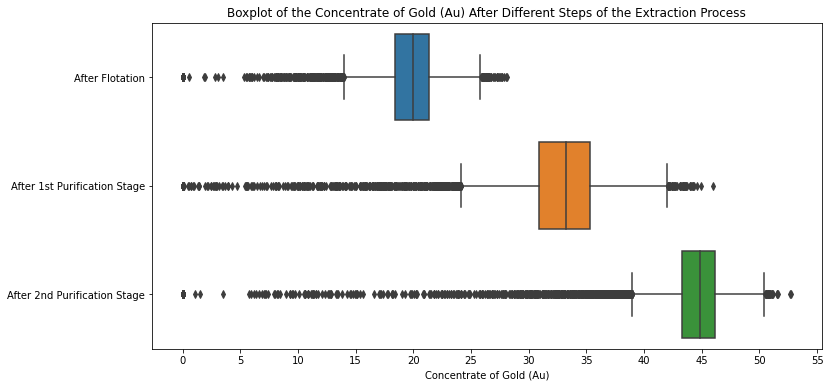

In [22]:
plt.figure(figsize = (12, 6))
boxplot_concentrate_au = sns.boxplot(data = df_for_au_boxplot, orient = 'h', x = 'concentrate_au', y = 'which_step')
plt.title('Boxplot of the Concentrate of Gold (Au) After Different Steps of the Extraction Process')
plt.xlabel('Concentrate of Gold (Au)')
plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55])
plt.ylabel('')
boxplot_concentrate_au.set_yticklabels(['After Flotation', 'After 1st Purification Stage', 'After 2nd Purification Stage'])
plt.show()

I am not at all an expert regarding the process of extracting gold from ore, however this seems like a great result! In a nutshell, what is happening is that after each stage of the purification process the concentrate of gold is typically significantly higher than what it was in the previous step. Among other values, the 25th, 50th, and 75th percentiles are all larger after each stage. This implies that the process is quite effective at extracting gold, as it should be!

In [23]:
print("The summary statistics of the values of the concentrate of lead after flotation are:")
print(gold_recovery_train['rougher.output.concentrate_pb'].describe())
print()
print("The summary statistics of the values of the concentrate of lead after the 1st purification stage are:")
print(gold_recovery_train['primary_cleaner.output.concentrate_pb'].describe())
print()
print("The summary statistics of the values of the concentrate of lead after the 2nd purification stage are:")
print(gold_recovery_train['final.output.concentrate_pb'].describe())

The summary statistics of the values of the concentrate of lead after flotation are:
count    14149.000000
mean         7.664555
std          1.856279
min          0.000000
25%          6.850501
50%          7.760435
75%          8.601927
max         13.617072
Name: rougher.output.concentrate_pb, dtype: float64

The summary statistics of the values of the concentrate of lead after the 1st purification stage are:
count    14149.000000
mean         9.568544
std          2.709330
min          0.000000
25%          8.315997
50%          9.920598
75%         11.298487
max         17.081278
Name: primary_cleaner.output.concentrate_pb, dtype: float64

The summary statistics of the values of the concentrate of lead after the 2nd purification stage are:
count    14149.000000
mean        10.132848
std          1.654925
min          0.000000
25%          9.296833
50%         10.297013
75%         11.170578
max         17.031899
Name: final.output.concentrate_pb, dtype: float64


In [24]:
df_for_pb_boxplot = pd.DataFrame()

df_for_pb_boxplot['concentrate_pb'] = pd.concat([gold_recovery_train['rougher.output.concentrate_pb'].copy(),
                                                 gold_recovery_train['primary_cleaner.output.concentrate_pb'].copy(),
                                                 gold_recovery_train['final.output.concentrate_pb'].copy()], 
                                                 ignore_index = True)

df_for_pb_boxplot['which_step'] = pd.concat([pd.Series(['flotation_output']*len(gold_recovery_train), name = 'step'),
                                             pd.Series(['primary_cleaner_output']*len(gold_recovery_train), name = 'step'),
                                             pd.Series(['final_output']*len(gold_recovery_train), name = 'step')], 
                                             ignore_index = True)

df_for_pb_boxplot.reset_index(drop = True, inplace = True)

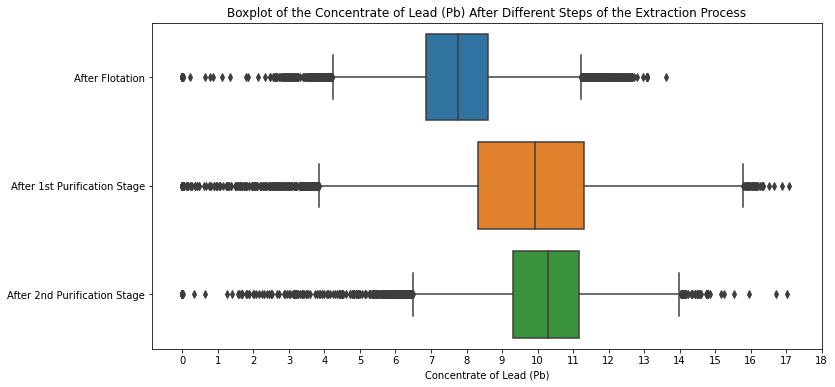

In [25]:
plt.figure(figsize = (12, 6))
boxplot_concentrate_pb = sns.boxplot(data = df_for_pb_boxplot, orient = 'h', x = 'concentrate_pb', y = 'which_step')
plt.title('Boxplot of the Concentrate of Lead (Pb) After Different Steps of the Extraction Process')
plt.xlabel('Concentrate of Lead (Pb)')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18])
plt.ylabel('')
boxplot_concentrate_pb.set_yticklabels(['After Flotation', 'After 1st Purification Stage', 'After 2nd Purification Stage'])
plt.show()

What I find most interesting about this distribution is that after the first purification stage, the 50th and 75th percentile values become considerably larger when compared to the values after flotation (but before the first purification), but the same cannot be said about what happens after the second purification stage. Indeed, the 50th and 75th percentile concentrate values of lead after the second purification stage are hardly any different (although the 25th percentile value is considerably larger); what is different about the distribution is how much "tighter" it is compared to that of after the first purification stage.

In [26]:
print("The summary statistics of the values of the concentrate of silver after flotation are:")
print(gold_recovery_train['rougher.output.concentrate_ag'].describe())
print()
print("The summary statistics of the values of the concentrate of silver after the 1st purification stage are:")
print(gold_recovery_train['primary_cleaner.output.concentrate_ag'].describe())
print()
print("The summary statistics of the values of the concentrate of silver after the 2nd purification stage are:")
print(gold_recovery_train['final.output.concentrate_ag'].describe())

The summary statistics of the values of the concentrate of silver after flotation are:
count    14149.000000
mean        11.775812
std          2.731747
min          0.000000
25%         10.486871
50%         11.747362
75%         13.426419
max         24.480271
Name: rougher.output.concentrate_ag, dtype: float64

The summary statistics of the values of the concentrate of silver after the 1st purification stage are:
count    14149.000000
mean         8.200916
std          2.005185
min          0.000000
25%          7.107126
50%          8.226247
75%          9.504924
max         16.081632
Name: primary_cleaner.output.concentrate_ag, dtype: float64

The summary statistics of the values of the concentrate of silver after the 2nd purification stage are:
count    14149.000000
mean         5.141921
std          1.369603
min          0.000000
25%          4.211500
50%          4.994607
75%          5.859495
max         16.001945
Name: final.output.concentrate_ag, dtype: float64


In [27]:
df_for_ag_boxplot = pd.DataFrame()

df_for_ag_boxplot['concentrate_ag'] = pd.concat([gold_recovery_train['rougher.output.concentrate_ag'].copy(),
                                                 gold_recovery_train['primary_cleaner.output.concentrate_ag'].copy(),
                                                 gold_recovery_train['final.output.concentrate_ag'].copy()], 
                                                 ignore_index = True)

df_for_ag_boxplot['which_step'] = pd.concat([pd.Series(['flotation_output']*len(gold_recovery_train), name = 'step'),
                                             pd.Series(['primary_cleaner_output']*len(gold_recovery_train), name = 'step'),
                                             pd.Series(['final_output']*len(gold_recovery_train), name = 'step')], 
                                                 ignore_index = True)

df_for_ag_boxplot.reset_index(drop = True, inplace = True)

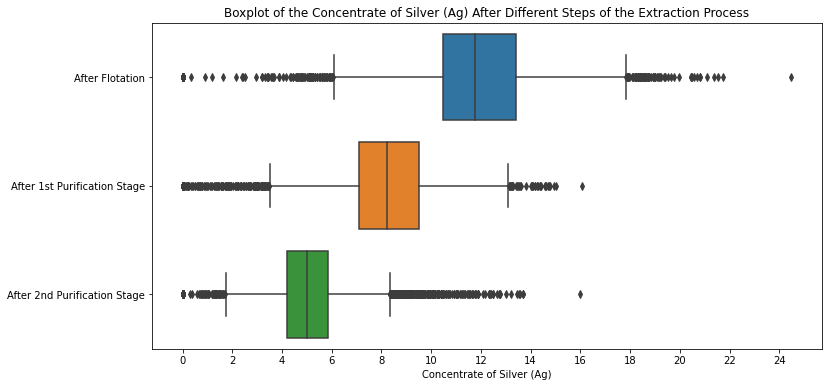

In [28]:
plt.figure(figsize = (12, 6))
boxplot_concentrate_ag = sns.boxplot(data = df_for_ag_boxplot, orient = 'h', x = 'concentrate_ag', y = 'which_step')
plt.title('Boxplot of the Concentrate of Silver (Ag) After Different Steps of the Extraction Process')
plt.xlabel('Concentrate of Silver (Ag)')
plt.xticks([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24])
plt.ylabel('')
boxplot_concentrate_ag.set_yticklabels(['After Flotation', 'After 1st Purification Stage', 'After 2nd Purification Stage'])
plt.show()

Fascinating! Of the three metals, silver is the only one whose concentrate tends to **decrease** (quite significantly at that) after each purification stage.

If they don't already know this, then **Zyfra** stakeholders should know that their extraction process increases the concentrate of gold and (to a lesser extent) lead at the expense of the concentrate of silver (which might be a problem because silver, while not as valuable as gold, is still quite valuable).

<b><u>PART B</u>: Comparing the Feed Particle Size Distributions In the Training Set and In the Test Set</b> <a id=6.2></a>

Notice that both the training set and the test set have columns named ``rougher.input.feed_size`` and ``primary_cleaner.input.feed_size``.

I must check the distributions of these values; if they vary significantly, then the model evaluation will be incorrect.

After consulting with a TripleTen tutor, I became convinced that Kernel Density Estimate (KDE) plots are appropriate for this check. (These plots estimate the probability density functions of the four distributions.)

To make comparing the distributions as easy as possible, the rougher input feed sizes are plotted together, as are the primary cleaner feed sizes.

I deliberately limited the x values on both plots because most of them occur within a relatively small interval of values.

Lastly, I also use the **describe** function to display the summary statistics of each distribution.

In [29]:
print("The summary statistics of the values of the rougher input feed sizes in the training set are:")
print(gold_recovery_train['rougher.input.feed_size'].describe())
print()
print("The summary statistics of the values of the rougher input feed sizes in the test set are:")
print(gold_recovery_test['rougher.input.feed_size'].describe())

The summary statistics of the values of the rougher input feed sizes in the training set are:
count    14149.000000
mean        60.239856
std         23.005310
min          9.659576
25%         48.966751
50%         55.269784
75%         66.007526
max        484.967466
Name: rougher.input.feed_size, dtype: float64

The summary statistics of the values of the rougher input feed sizes in the test set are:
count    5856.000000
mean       55.898866
std        22.707969
min         0.046369
25%        43.852884
50%        49.964796
75%        61.628003
max       477.445473
Name: rougher.input.feed_size, dtype: float64


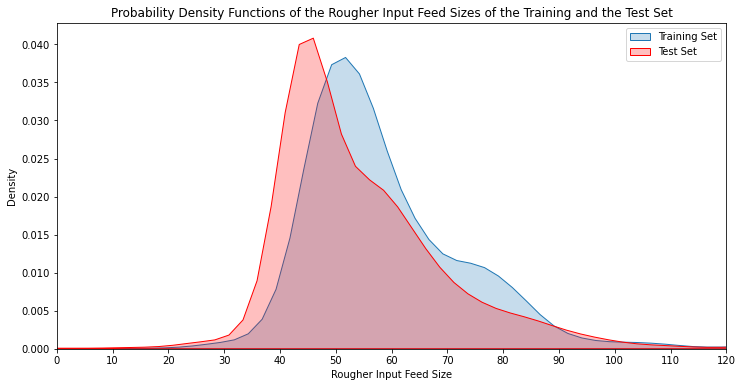

In [30]:
plt.figure(figsize = (12, 6))

sns.kdeplot(gold_recovery_train['rougher.input.feed_size'], fill = True, label = 'Training Set')
sns.kdeplot(gold_recovery_test['rougher.input.feed_size'], fill = True, label = 'Test Set', color = 'red')

plt.legend()
plt.title('Probability Density Functions of the Rougher Input Feed Sizes of the Training and the Test Set')
plt.xlabel('Rougher Input Feed Size')
plt.xlim(0, 120)
plt.xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120])
plt.ylabel('Density')

plt.show()

Excellent! The summary statistics and the plots both strongly suggest that the two rougher input feed size distributions are very similar!

In [31]:
print("The summary statistics of the values of the primary cleaner feed sizes in the training set are:")
print(gold_recovery_train['primary_cleaner.input.feed_size'].describe())
print()
print("The summary statistics of the values of the primary cleaner feed sizes in the test set are:")
print(gold_recovery_test['primary_cleaner.input.feed_size'].describe())

The summary statistics of the values of the primary cleaner feed sizes in the training set are:
count    14149.000000
mean         7.322310
std          0.614062
min          1.080000
25%          6.960000
50%          7.290000
75%          7.700000
max         10.470000
Name: primary_cleaner.input.feed_size, dtype: float64

The summary statistics of the values of the primary cleaner feed sizes in the test set are:
count    5856.000000
mean        7.264651
std         0.611526
min         5.650000
25%         6.885625
50%         7.259333
75%         7.650000
max        15.500000
Name: primary_cleaner.input.feed_size, dtype: float64


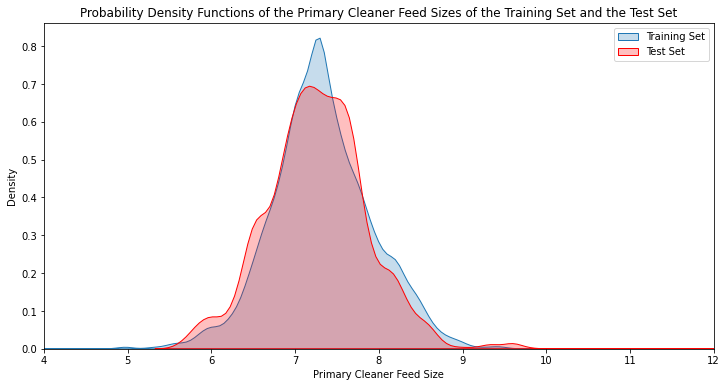

In [32]:
plt.figure(figsize = (12, 6))

sns.kdeplot(gold_recovery_train['primary_cleaner.input.feed_size'], fill = True, label = 'Training Set')
sns.kdeplot(gold_recovery_test['primary_cleaner.input.feed_size'], fill = True, label = 'Test Set', color = 'red')

plt.legend()
plt.title('Probability Density Functions of the Primary Cleaner Feed Sizes of the Training Set and the Test Set')
plt.xlabel('Primary Cleaner Feed Size')
plt.xlim(4, 12)
plt.ylabel('Density')

plt.show()

Once again, excellent! The two primary cleaner feed size distributions appear to be very similar as well!

Interestingly, there is a ***MUCH*** wider interval of possible rougher input feed sizes than primary cleaner feed sizes.

<b><u>PART C</u>: Are There Any Abnormal Values In the Total Distribution?</b> <a id=6.3></a>

To help me search for possible abnormal values, I must consider the amounts of all substances at each key stage: raw feed, rougher concentrate, and final concentrate. If I do find any abnormal values, then they should be removed from both the training set and the test set, otherwise they might cause my machine learning model to be less accurate than it otherwise would be.

A well-known method for detecting outliers is the **Interquartile Range (IQR) Method**, which I will use here. According to this method, a data point is an outlier if it is more than 1.5 times the IQR below the first quartile or above the third quartile.

For each metal (Au, Pb, and Ag), I will search for, and drop, outliers from their corresponding columns of the following names:

``rougher.input.feed``, ``rougher.output.concentrate``, and ``final.output.concentrate``

In [33]:
def drop_outliers_iqr(df, columns):
    for column in columns:
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

In [34]:
gold_recovery_train_no_outliers = drop_outliers_iqr(gold_recovery_train.copy(), ['rougher.input.feed_ag', 
                                                                                 'rougher.output.concentrate_ag', 
                                                                                 'final.output.concentrate_ag',
                                                                                 
                                                                                 'rougher.input.feed_pb', 
                                                                                 'rougher.output.concentrate_pb', 
                                                                                 'final.output.concentrate_pb',
                                                                                 
                                                                                 'rougher.input.feed_au', 
                                                                                 'rougher.output.concentrate_au', 
                                                                                 'final.output.concentrate_au'])

display(gold_recovery_train_no_outliers.shape)

(11802, 87)

Note that this dataframe has gone from having 16,860 entries to 11,802. 

While it is unfortunate that quite a lot of entries were dropped, I think it is for the best. Thankfully 11,802 is still a lot of data to work with.

In [35]:
gold_recovery_test_no_outliers = drop_outliers_iqr(gold_recovery_test.copy(), ['rougher.input.feed_ag', 
                                                                               'rougher.input.feed_pb', 
                                                                               'rougher.input.feed_au'])

display(gold_recovery_test_no_outliers.shape)

(5254, 53)

This dataframe has gone from having 5,856 entries to 5,254. This is still plenty of data to work with.

# Section 3: Building the Model <a id=7></a>

<b><u>PART A</u>: Writing a Function to Calculate the Final sMAPE Value</b> <a id=7.1></a>

I displayed the formula for sMAPE back in **Feature Naming**, however I display it once again here, as well as the formula for Final sMAPE, for reference.

In [36]:
display(Image(url = 'https://practicum-content.s3.us-west-1.amazonaws.com/resources/moved_smape_1576238825_1589899257.jpg'))

Note that dividing the denominator by 2 is mathematically equivalent to multiplying the numerator by 2. I write my function with this in mind.

In [37]:
display(Image(url = 'https://practicum-content.s3.us-west-1.amazonaws.com/resources/moved__smape_1589899561.jpg'))

In [38]:
def smape(y_target, y_predicted):
    return np.sum(2 * np.abs(y_target - y_predicted) / ((np.abs(y_target) + np.abs(y_predicted)))) / len(y_target) * 100

def final_smape(rougher_concentrate_smape, final_concentrate_smape):
    return 0.25 * rougher_concentrate_smape + 0.75 * final_concentrate_smape

<b><u>PART B</u>: Training Different Models and Testing the Best One Using the Test Sample</b> <a id=7.2></a>

I will train three different models: a **decision tree regressor**, a **linear regression**, and a **random forest regressor**.

Recall that the target features for the models are ```rougher.output.recovery``` and ```final.output.recovery```.

Whichever of the three models has the smallest **Final sMAPE** value is the one that I will deem the best one to test with.

I will be sure to evaluate each model using cross-validation. 

In particular, I set the **cv** parameter equal to 5 because that gives me multiple samples without being too computationally expensive. (In my draft, I toyed with setting **cv** to 10 but this made the **random forest regressor** especially computationally expensive.)

Last, but not least, I must only use features that appear in both the training set and the test set. The next line of code makes sure of this.

In [39]:
date_and_targets = ['date', 'rougher.output.recovery', 'final.output.recovery']

features_not_in_test_set = ['final.output.concentrate_ag', 'final.output.concentrate_au', 'final.output.concentrate_pb',
                            'final.output.concentrate_sol', 'final.output.recovery', 'final.output.tail_ag',
                            'final.output.tail_au', 'final.output.tail_pb', 'final.output.tail_sol', 
                            'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_au',
                            'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_sol',
                            'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_au', 
                            'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol',
                            'rougher.calculation.au_pb_ratio', 'rougher.calculation.floatbank10_sulfate_to_au_feed',
                            'rougher.calculation.floatbank11_sulfate_to_au_feed', 
                            'rougher.calculation.sulfate_to_au_concentrate', 'rougher.output.concentrate_ag',
                            'rougher.output.concentrate_au', 'rougher.output.concentrate_pb', 
                            'rougher.output.concentrate_sol', 'rougher.output.recovery', 'rougher.output.tail_ag',
                            'rougher.output.tail_au', 'rougher.output.tail_pb', 'rougher.output.tail_sol',
                            'secondary_cleaner.output.tail_ag', 'secondary_cleaner.output.tail_au', 
                            'secondary_cleaner.output.tail_pb', 'secondary_cleaner.output.tail_sol']

features_to_drop = date_and_targets + features_not_in_test_set

features = gold_recovery_train_no_outliers.drop(features_to_drop, axis = 1).copy()

targets = gold_recovery_train_no_outliers[['rougher.output.recovery', 'final.output.recovery']].copy()

The reason why I set **max_depth** equal to 4 is because in my draft I wrote a for loop that tested every **max_depth** value between 1 and 30 (inclusive), and 4 is the value that gave me the smallest mean final sMAPE value.

In [40]:
decision_tree_model = DecisionTreeRegressor(max_depth = 4, random_state = 12345)

rougher_concentrate_smape_tree = cross_val_score(decision_tree_model, features, 
                                                 targets['rougher.output.recovery'], 
                                                 cv = 5, scoring = make_scorer(smape))

final_concentrate_smape_tree = cross_val_score(decision_tree_model, features, 
                                               targets['final.output.recovery'], 
                                               cv = 5, scoring = make_scorer(smape))

final_smape_tree = final_smape(rougher_concentrate_smape_tree, final_concentrate_smape_tree)

print("All Final sMAPE Values of the Decision Tree Regressor Model:") 
print(np.sort(final_smape_tree))
print()
print("Mean Final sMAPE Value of the Decision Tree Regressor Model:", final_smape_tree.mean())

All Final sMAPE Values of the Decision Tree Regressor Model:
[7.36130113 7.71053431 8.08030688 9.14036021 9.53957187]

Mean Final sMAPE Value of the Decision Tree Regressor Model: 8.366414879446479


In [41]:
linear_regression_model = LinearRegression()

rougher_concentrate_smape_linear = cross_val_score(linear_regression_model, features, targets['rougher.output.recovery'], 
                                                   cv = 5, scoring = make_scorer(smape))

final_concentrate_smape_linear = cross_val_score(linear_regression_model, features, targets['final.output.recovery'], 
                                                 cv = 5, scoring = make_scorer(smape))

final_smape_linear = final_smape(rougher_concentrate_smape_linear, final_concentrate_smape_linear)

print("All Final sMAPE Values of the Linear Regression Model:") 
print(np.sort(final_smape_linear))
print()
print("Mean Final sMAPE Value of the Linear Regression Model:", final_smape_linear.mean())

All Final sMAPE Values of the Linear Regression Model:
[ 7.36010724  7.6481617   8.80750359  9.77955067 11.99685893]

Mean Final sMAPE Value of the Linear Regression Model: 9.118436426077809


The **decision tree regressor** is noticeably more accurate than the linear regression (by about 1 percentage point). 

That said, random forest regressors are usually more accurate than decision tree regressors, at the expense of being more computationally expensive. 

If my **random forest regressor** is more accurate ***AND*** is not overly computationally expensive, then I will choose it over the **decision tree regressor**.

Similar to what I did with the **decision tree regressor**, I examined which values to set the hyperparameters (namely, **max_depth** and **n_estimators**) equal to in order to minimize the mean final sMAPE value.

In [42]:
random_forest_model = RandomForestRegressor(max_depth = 4, n_estimators = 8, random_state = 12345)

rougher_concentrate_smape_forest = cross_val_score(random_forest_model, features, targets['rougher.output.recovery'], 
                                                   cv = 5, scoring = make_scorer(smape))

final_concentrate_smape_forest = cross_val_score(random_forest_model, features, targets['final.output.recovery'], 
                                                 cv = 5, scoring = make_scorer(smape))

final_smape_forest = final_smape(rougher_concentrate_smape_forest, final_concentrate_smape_forest)

print("All Final sMAPE Values of the Random Forest Regressor Model:") 
print(np.sort(final_smape_forest))
print()
print("Mean Final sMAPE Value of the Random Forest Regressor Model:", final_smape_forest.mean())

All Final sMAPE Values of the Random Forest Regressor Model:
[7.16775397 7.30840464 7.98138224 8.05560417 8.96015038]

Mean Final sMAPE Value of the Random Forest Regressor Model: 7.894659079094081


Though the **random forest regressor** is a little computationally expensive, I will choose it because it is about 0.5 percentage point more accurate than the **decision tree regressor**, and accuracy is crucial in the context of extracting valuable metals such as gold.

As a sanity check, it is a good idea to compare my model to a **dummy regressor**, in which I use the median for the **strategy** parameter.

In [43]:
dummy_model = DummyRegressor(strategy = 'median')

rougher_concentrate_smape_dummy = cross_val_score(dummy_model, features, 
                                                  targets['rougher.output.recovery'], 
                                                  cv = 5, scoring = make_scorer(smape))

final_concentrate_smape_dummy = cross_val_score(dummy_model, features, 
                                                targets['final.output.recovery'], 
                                                cv = 5, scoring = make_scorer(smape))

final_smape_dummy = final_smape(rougher_concentrate_smape_dummy, final_concentrate_smape_dummy)

print("All Final sMAPE Values of the Dummy Regressor:")
print(np.sort(final_smape_dummy))
print()
print("Mean Final sMAPE Value of the Dummy Regressor:", final_smape_dummy.mean())

All Final sMAPE Values of the Dummy Regressor:
[7.90222719 8.18371373 9.13310227 9.67806864 9.76614891]

Mean Final sMAPE Value of the Dummy Regressor: 8.932652148063664


Oddly enough, the **dummy regressor** is actually ***more*** accurate than the **linear regression**! 

Furthermore, it is not much less accurate than the **decision tree regressor**. 

The **random forest regressor** is a little more than 1 percentage point more accurate. I will now look at the distributions of the ```rougher.output.recovery``` and ```final.output.recovery``` values to get an idea of how significant this is.

In [44]:
print('The summary statistics of the rougher concentrate recovery values are:')
display(targets['rougher.output.recovery'].describe())
print()
print('The summary statistics of the final concentrate recovery values are:')
display(targets['final.output.recovery'].describe())

The summary statistics of the rougher concentrate recovery values are:


count    11802.000000
mean        84.673130
std          7.286246
min         33.571847
25%         80.455354
50%         85.451570
75%         90.175798
max         99.301102
Name: rougher.output.recovery, dtype: float64


The summary statistics of the final concentrate recovery values are:


count    11802.000000
mean        67.226146
std          8.204108
min         12.641445
25%         63.063849
50%         67.510756
75%         72.311483
max        100.000000
Name: final.output.recovery, dtype: float64

Notice that in both distributions, the 25th percentile and the 75th percentile are approximately equidistant from the 50th percentile (median). Furthermore, in both distributions the IQR is quite small, between 9 and 10. This implies that the distributions are "tight", which suggests to me that it is actually quite difficult to make a model that is superior to the **dummy regressor**. Due to this, I think it is an impressive result that the **random forest regressor** is (a little) more than 1 percentage point more accurate than the **dummy regressor**!

I am curious to see how the predicted targets values compare to the actual targets values of the test set, which are found in the full set. On the next line, I use the **date** columns of the **gold_recovery_test_no_outliers** and **gold_recovery_full** dataframes to merge the dataframes in order to find the actual targets values of the test set that are located in the full set.

In [45]:
test_and_full_sets_merged = pd.merge(gold_recovery_test_no_outliers, 
                                     gold_recovery_full[['date', 'rougher.output.recovery', 'final.output.recovery']], 
                                     how = 'inner', on = 'date')

test_and_full_sets_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5254 entries, 0 to 5253
Data columns (total 55 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5254 non-null   object 
 1   primary_cleaner.input.sulfate               5254 non-null   float64
 2   primary_cleaner.input.depressant            5254 non-null   float64
 3   primary_cleaner.input.feed_size             5254 non-null   float64
 4   primary_cleaner.input.xanthate              5254 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5254 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5254 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5254 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5254 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5254 non-null   float64
 10  primary_clea

Hmm... for one reason or another, there are a relatively small number of null ```rougher.output.recovery``` and ```final.output.recovery``` values.

The next line drops the rows that have a null ```rougher.output.recovery``` and/or ```final.output.recovery``` value.

In [46]:
test_and_full_sets_merged.dropna(inplace = True)
test_and_full_sets_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5102 entries, 0 to 5253
Data columns (total 55 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5102 non-null   object 
 1   primary_cleaner.input.sulfate               5102 non-null   float64
 2   primary_cleaner.input.depressant            5102 non-null   float64
 3   primary_cleaner.input.feed_size             5102 non-null   float64
 4   primary_cleaner.input.xanthate              5102 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5102 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5102 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5102 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5102 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5102 non-null   float64
 10  primary_clea

This merged dataframe has gone from having 5254 rows to 5102. Thankfully, this is a relatively small decrease.

Now I am equipped to measure how the predicted targets values compare to the actual targets values of the test set.

My next lines of code do the following, in this order:

1) Fit my random forest regressor with the **features** and **targets** dataframes.

2) Put the features of **test_and_full_sets_merged** into their own dataframe, and apply the **predict** function to that new dataframe.

3) Store the actual targets values of the test set into one dataframe, and the predicted targets values of the test set into another.

4) Use my **smape** and **final_smape** functions to calculate the final sMAPE value of the test set.

In [47]:
random_forest_model.fit(features, targets)

RandomForestRegressor(max_depth=4, n_estimators=8, random_state=12345)

In [48]:
test_and_full_sets_merged_features = (test_and_full_sets_merged.drop(['date','rougher.output.recovery',
                                                                     'final.output.recovery'], axis = 1).copy())

random_forest_model_test = random_forest_model.predict(test_and_full_sets_merged_features)

In [49]:
actual_targets_values_test = test_and_full_sets_merged[['rougher.output.recovery', 'final.output.recovery']].copy()

predicted_targets_values_test = pd.DataFrame(random_forest_model_test)
predicted_targets_values_test.rename(columns = {0: 'rougher.output.recovery', 1: 'final.output.recovery'}, inplace = True)

In [50]:
rougher_concentrate_smape_test = smape(actual_targets_values_test['rougher.output.recovery'], 
                                       predicted_targets_values_test['rougher.output.recovery'])

final_concentrate_smape_test = smape(actual_targets_values_test['final.output.recovery'], 
                                     predicted_targets_values_test['final.output.recovery'])

final_smape_test = final_smape(rougher_concentrate_smape_test, final_concentrate_smape_test)

print("Final sMAPE Value of the Test Set's Targets Values:", final_smape_test)

Final sMAPE Value of the Test Set's Targets Values: 8.819304813689158


While about 8.82 is noticeably larger than the about 7.89 I received when I used cross validation on the training set, I think that these two numbers are close enough in value to safely assume that I correctly applied the model to the test set.

# Conclusion <a id=8></a>

I am happy to inform **Zyfra** stakeholders that my project has acquired helpful results, including a prototype of a machine learning model that predicts the amount of gold recovered from ore.

In chronological order, here are the key results of the project:

(1) The ```rougher.output.recovery``` values of the training set are calculated correctly.

(2) I found out which features appear in the training set, but not the test set. Hence, I only used the mutual features to train the model.

(3) As ore undergoes purification, after each stage the concentrates of gold and (to a lesser extent) lead increase, but silver's concentrate decreases.

(4) The feed particle size distributions of the training set are very similar to those of the test set, which is crucial because if they were not, then the machine learning's model would be inaccurate.

(5) I used the IQR Method to remove outliers from the total concentrations of all the metals (gold, lead, and silver) at each key stage: raw feed, rougher concentrate, and final concentrate. Doing this surely helped improve the accuracy of the prototype.

(6) After evaluating three models — a decision tree regressor, a linear regression, and a random forest regressor — using cross-validation, I found the random forest regressor to be the most accurate one, as determined by the sMAPE values of the models.

(7) I compared the random forest regressor to a dummy regressor (using the median value as the "strategy") and, thankfully, I found the random forest regressor to be more accurate.

(8) I used the random forest regressor to predict the rougher.output.recovery and final.output.recovery values of the test set, and I found that the sMAPE value between the actual recovery values and the predicted recovery values is similar to the sMAPE value I got from using cross validation on the training set.

I am convinced that the above results give strong evidence that suggests the prototype model has potential to accurately approximate the amount of gold recovered from ore.